# <center>Курсовой проект<a class="anchor" id="course_project"></a><center>

**Постановка задачи**<a class="anchor" id="course_project_task"></a>

**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет


**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}\_solution.ipynb, пример SShirkin\_solution.ipynb
2. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}\_predictions.csv, пример SShirkin\_predictions.csv

*Рекомендации для файла с кодом (ipynb)*
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.

**Сроки сдачи**

Cдать проект нужно в течение 5 дней после окончания последнего вебинара.
Оценки работ, сданных до дедлайна, будут представлены в виде рейтинга, ранжированного по заданной метрике качества.
Проекты, сданные после дедлайна или сданные повторно, не попадают в рейтинг, но можно будет узнать результат.

**Примерное описание этапов выполнения курсового проекта**<a class="anchor" id="course_project_steps"></a>

**Построение модели классификации**
1. Обзор обучающего датасета
2. Обработка выбросов
3. Обработка пропусков
4. Анализ данных
5. Отбор признаков
6. Балансировка классов
7. Подбор моделей, получение бейзлана
8. Выбор наилучшей модели, настройка гиперпараметров
9. Проверка качества, борьба с переобучением
10. Интерпретация результатов

**Прогнозирование на тестовом датасете**
1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков
2. Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете
3. Прогнозы должны быть для всех примеров из тестового датасета (для всех строк)
4. Соблюдать исходный порядок примеров из тестового датасета

# Обзор данных<a class="anchor" id="course_project_review"></a>

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

# Загрузка библиотек и данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import tqdm
import re

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (roc_auc_score, roc_curve, auc, confusion_matrix, f1_score, \
                             accuracy_score, classification_report, plot_confusion_matrix, \
                             plot_precision_recall_curve, precision_recall_curve, recall_score,
                             plot_roc_curve)

In [2]:
# !pip install xgboost
# !pip install lightgbm
# !pip install catboost

**Пути к директориям и файлам**

In [3]:
TRAIN_DATASET_PATH = './data/course_project_train.csv'
TEST_DATASET_PATH = './data/course_project_test.csv'

**Загрузка данных**

In [4]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)

In [5]:
# разбиение признаков на числовые и категориальные
FEATURES = df_train.columns.to_list()

TARGET_NAME = 'Credit Default'

NUM_FEATURE_NAMES = ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History',
            'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent',
            'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score']

# получаем категориальные признаки вычитая из всех признаков числовые и целевой признак
CAT_FEATURE_NAMES = [item for item in FEATURES if item not in NUM_FEATURE_NAMES]

CAT_FEATURE_NAMES.remove(TARGET_NAME)

SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + CAT_FEATURE_NAMES #+ NEW_FEATURE_NAMES

# Функции

In [6]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [7]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [8]:
def balance_df_by_target(df, target_name, method='over'):

    assert method in ['over', 'under'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)


    return df.sample(frac=1) 

In [9]:
def LogRegression(df, C=1):

    # Заполняем пропуски модой
    #df.fillna(df.mode().iloc[0], inplace=True)
    #df = df.fillna(df.median(axis=0), axis=0)

    # Переводим категориальные признаки в количественные
    df = pd.get_dummies(df)

    # стандиртизируем данные
    scaler = StandardScaler()
    df_norm = df.copy()
    df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])
    df = df_norm.copy()
    
    # форммруем выборки
    X = df.drop(columns=[TARGET_NAME])
    y = df[TARGET_NAME]

    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        shuffle=True,
                                                        test_size=0.3,
                                                        random_state=21,
                                                        stratify=y)
    # обучаем модель
    model = LogisticRegression(C=C,
                              )
    model.fit(X_train, y_train)

    # предсказываем
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # считаем метрики
    #evaluate_preds(model, X_train, X_test, y_train, y_test)
    accuracy_train = accuracy_score(y_train, y_train_pred)
    accuracy_test = accuracy_score(y_test, y_test_pred)
    
    return f'f1 class 1: TRAIN = {round(accuracy_train, 4)}, TEST = {round(accuracy_test, 4)}'

In [10]:
def knn(df):

    # Заполняем пропуски модой
    #df.fillna(df.mode().iloc[0], inplace=True)
    #df = df.fillna(df.median(axis=0), axis=0)

    # Переводим категориальные признаки в количественные
    df = pd.get_dummies(df)

    # стандиртизируем данные
#     scaler = StandardScaler()
#     df_norm = df.copy()
#     df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])
#     df = df_norm.copy()
    
    # форммруем выборки
    X = df.drop(columns=[TARGET_NAME])
    y = df[TARGET_NAME]

    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        shuffle=True,
                                                        test_size=0.3,
                                                        random_state=21,
                                                        stratify=y)
    # обучаем модель
    model = KNeighborsClassifier()
    model.fit(X_train, y_train)

    # предсказываем
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # считаем метрики
    #evaluate_preds(model, X_train, X_test, y_train, y_test)
    accuracy_train = accuracy_score(y_train, y_train_pred)
    accuracy_test = accuracy_score(y_test, y_test_pred)
    
    return f'f1 class 1: TRAIN = {round(accuracy_train, 4)}, TEST = {round(accuracy_test, 4)}'

In [11]:
def decision_tree(df, max_depth):

    # подсчитываем дисбаланс классов
    class_weight = df[TARGET_NAME].value_counts()[1] / df[TARGET_NAME].value_counts()[0]
    
    # Заполняем пропуски модой
    #df.fillna(df.mode().iloc[0], inplace=True)
    #df = df.fillna(df.median(axis=0), axis=0)

    # Переводим категориальные признаки в количественные
    df = pd.get_dummies(df)

    # стандиртизируем данные
#     scaler = StandardScaler()
#     df_norm = df.copy()
#     df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])
#     df = df_norm.copy()
        
    # формируем выборки
    X = df.drop(columns=[TARGET_NAME])
    y = df[TARGET_NAME]

    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        shuffle=True,
                                                        test_size=0.3,
                                                        random_state=21,
                                                        stratify=y)
    # обучаем модель
    model = DecisionTreeClassifier(random_state=21,
                                    class_weight={0:class_weight, 1:1},
                                    max_depth=max_depth
                                    )
    model.fit(X_train, y_train)

    # предсказываем
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # считаем метрики
    #evaluate_preds(model, X_train, X_test, y_train, y_test)
    accuracy_train = accuracy_score(y_train, y_train_pred)
    accuracy_test = accuracy_score(y_test, y_test_pred)
    
    return f'f1 class 1: TRAIN = {round(accuracy_train, 4)}, TEST = {round(accuracy_test, 4)}'

In [12]:
def xgboost(df, n_estimators=100, max_depth=6, max_leaves=0, reg_alpha=0, reg_lambda=1):

    # подсчитываем дисбаланс классов
    #class_weight = df[TARGET_NAME].value_counts()[1] / df[TARGET_NAME].value_counts()[0]
    
    # Заполняем пропуски модой
    #df.fillna(df.mode().iloc[0], inplace=True)
    #df = df.fillna(df.median(axis=0), axis=0)

    # Переводим категориальные признаки в количественные
    df = pd.get_dummies(df)
    
    # после перевода в категориальные данные появляется столбец 
    # 'Years in current job_< 1 year', необходимо заменить знак <
    #df_clean = df
    regex = re.compile(r"\[|\]|<", re.IGNORECASE)
    df.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) \
                       else col for col in df.columns.values]
    
    # стандиртизируем данные
#     scaler = StandardScaler()
#     df_norm = df.copy()
#     df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])
#     df = df_norm.copy()
        
    # формируем выборки
    X = df.drop(columns=[TARGET_NAME])
    y = df[TARGET_NAME]

    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        shuffle=True,
                                                        test_size=0.3,
                                                        random_state=21,
                                                        stratify=y)
    # обучаем модель
    model = xgb.XGBClassifier(random_state=21,
                              n_estimators=n_estimators,
                              max_depth=max_depth, 
                              max_leaves=max_leaves, 
                              reg_alpha=reg_alpha, 
                              reg_lambda=reg_lambda
                             )
    model.fit(X_train, y_train)

    # предсказываем
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # считаем метрики
    #evaluate_preds(model, X_train, X_test, y_train, y_test)
    accuracy_train = accuracy_score(y_train, y_train_pred)
    accuracy_test = accuracy_score(y_test, y_test_pred)
    
    return f'f1 class 1: TRAIN = {round(accuracy_train, 4)}, TEST = {round(accuracy_test, 4)}'

In [13]:
def light_gbm(df, n_estimators=100, num_leaves=10):

    # подсчитываем дисбаланс классов
    class_weight = df[TARGET_NAME].value_counts()[1] / df[TARGET_NAME].value_counts()[0]
    
    # Заполняем пропуски модой
    #df.fillna(df.mode().iloc[0], inplace=True)
    #df = df.fillna(df.median(axis=0), axis=0)

    # Переводим категориальные признаки в количественные
    df = pd.get_dummies(df)
    
    # после перевода в категориальные данные появляется столбец 
    # 'Years in current job_< 1 year', необходимо заменить знак <
    #df_clean = df
    regex = re.compile(r"\[|\]|<", re.IGNORECASE)
    df.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) \
                       else col for col in df.columns.values]
    
    # стандиртизируем данные
#     scaler = StandardScaler()
#     df_norm = df.copy()
#     df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])
#     df = df_norm.copy()
        
    # формируем выборки
    X = df.drop(columns=[TARGET_NAME])
    y = df[TARGET_NAME]

    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        shuffle=True,
                                                        test_size=0.3,
                                                        random_state=21,
                                                        stratify=y)
    # обучаем модель
    model = lgbm.LGBMClassifier(random_state=21, 
                                 class_weight={0:class_weight, 1:1},
                                  n_estimators=n_estimators,
                                num_leaves=num_leaves
                               )
    model.fit(X_train, y_train)

    # предсказываем
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # считаем метрики
    #evaluate_preds(model, X_train, X_test, y_train, y_test)
    accuracy_train = accuracy_score(y_train, y_train_pred)
    accuracy_test = accuracy_score(y_test, y_test_pred)
    
    return f'f1 class 1: TRAIN = {round(accuracy_train, 4)}, TEST = {round(accuracy_test, 4)}'

**LightGBM**

**For Better Accuracy**
- Use large `max_bin` (may be slower)
- Use small learning_rate with large `num_iterations`
- Use large `num_leaves` (may cause over-fitting)
- Use bigger training data
- Try `dart`

**Deal with Over-fitting**
- Use small `max_bin`
- Use small `num_leaves`
- Use `min_data_in_leaf` and min_sum_hessian_in_leaf
- Use bagging by set `bagging_fraction` and `bagging_freq`
- Use feature sub-sampling by set `feature_fraction`
- Use bigger training data
- Try `lambda_l1`, `lambda_l2` and `min_gain_to_split` for regularization
- Try `max_depth` to avoid growing deep tree
- Try `extra_trees`
- Try increasing `path_smooth`

In [14]:
def cat_boost(df, n_estimators=100, num_leaves=10):

    # подсчитываем дисбаланс классов
    class_weight = df[TARGET_NAME].value_counts()[1] / df[TARGET_NAME].value_counts()[0]
    
    # Заполняем пропуски модой
    #df.fillna(df.mode().iloc[0], inplace=True)
    #df = df.fillna(df.median(axis=0), axis=0)

    # Переводим категориальные признаки в количественные
    #df = pd.get_dummies(df)
    
    # после перевода в категориальные данные появляется столбец 
    # 'Years in current job_< 1 year', необходимо заменить знак <
    #df_clean = df
#     regex = re.compile(r"\[|\]|<", re.IGNORECASE)
#     df.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) \
#                        else col for col in df.columns.values]
    
    # стандартизируем данные
#     scaler = StandardScaler()
#     df_norm = df.copy()
#     df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])
#     df = df_norm.copy()
        
    # формируем выборки
    X = df.drop(columns=[TARGET_NAME])
    y = df[TARGET_NAME]

    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        shuffle=True,
                                                        test_size=0.3,
                                                        random_state=21,
                                                        stratify=y)
    # обучаем модель
    model = catb.CatBoostClassifier(silent=True, random_state=21, 
                                    cat_features=CAT_FEATURE_NAMES,
                                    one_hot_max_size=len(X.columns),
                                    class_weights=[class_weight, 1],
                                    eval_metric='F1',
                                    custom_metric=['Precision', 'Recall'],
                                   )
    model.fit(X_train, y_train)

    # предсказываем
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # считаем метрики
    #evaluate_preds(model, X_train, X_test, y_train, y_test)
    accuracy_train = accuracy_score(y_train, y_train_pred)
    accuracy_test = accuracy_score(y_test, y_test_pred)
    
    return f'f1 class 1: TRAIN = {round(accuracy_train, 4)}, TEST = {round(accuracy_test, 4)}'

# EDA: обзор датасета

In [15]:
df_train.head().style.applymap(lambda x: 'color: red' if pd.isnull(x) else '')

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.000000,nan,0.000000,11.000000,26.300000,685960.000000,1.000000,nan,1.000000,debt consolidation,Short Term,99999999.000000,47386.000000,7914.000000,749.000000,0
1,Own Home,1025487.000000,10+ years,0.000000,15.000000,15.300000,1181730.000000,0.000000,nan,0.000000,debt consolidation,Long Term,264968.000000,394972.000000,18373.000000,737.000000,1
2,Home Mortgage,751412.000000,8 years,0.000000,11.000000,35.000000,1182434.000000,0.000000,nan,0.000000,debt consolidation,Short Term,99999999.000000,308389.000000,13651.000000,742.000000,0
3,Own Home,805068.000000,6 years,0.000000,8.000000,22.500000,147400.000000,1.000000,nan,1.000000,debt consolidation,Short Term,121396.000000,95855.000000,11338.000000,694.000000,0
4,Rent,776264.000000,8 years,0.000000,13.000000,13.600000,385836.000000,1.000000,nan,0.000000,debt consolidation,Short Term,125840.000000,93309.000000,7180.000000,719.000000,0


In [16]:
df_train.shape

(7500, 17)

In [17]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [18]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [19]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

In [20]:
df_test.head().style.applymap(lambda x: 'color: red' if pd.isnull(x) else '')

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,nan,4 years,0.000000,9.000000,12.500000,220968.000000,0.000000,70.000000,0.000000,debt consolidation,Short Term,162470.000000,105906.000000,6813.000000,nan
1,Rent,231838.000000,1 year,0.000000,6.000000,32.700000,55946.000000,0.000000,8.000000,0.000000,educational expenses,Short Term,78298.000000,46037.000000,2318.000000,699.000000
2,Home Mortgage,1152540.000000,3 years,0.000000,10.000000,13.700000,204600.000000,0.000000,nan,0.000000,debt consolidation,Short Term,200178.000000,146490.000000,18729.000000,7260.000000
3,Home Mortgage,1220313.000000,10+ years,0.000000,16.000000,17.000000,456302.000000,0.000000,70.000000,0.000000,debt consolidation,Short Term,217382.000000,213199.000000,27559.000000,739.000000
4,Home Mortgage,2340952.000000,6 years,0.000000,11.000000,23.600000,1207272.000000,0.000000,nan,0.000000,debt consolidation,Long Term,777634.000000,425391.000000,42605.000000,706.000000


In [21]:
df_test.shape

(2500, 16)

Количество уникальных значений

In [22]:
df_train.nunique()

Home Ownership                     4
Annual Income                   5478
Years in current job              11
Tax Liens                          8
Number of Open Accounts           39
Years of Credit History          408
Maximum Open Credit             6963
Number of Credit Problems          8
Months since last delinquent      89
Bankruptcies                       5
Purpose                           15
Term                               2
Current Loan Amount             5386
Current Credit Balance          6592
Monthly Debt                    6716
Credit Score                     268
Credit Default                     2
dtype: int64

In [23]:
df_test.nunique()

Home Ownership                     4
Annual Income                   1929
Years in current job              11
Tax Liens                          8
Number of Open Accounts           35
Years of Credit History          345
Maximum Open Credit             2435
Number of Credit Problems          8
Months since last delinquent      83
Bankruptcies                       6
Purpose                           14
Term                               2
Current Loan Amount             2026
Current Credit Balance          2385
Monthly Debt                    2416
Credit Score                     211
dtype: int64

## Обзор категориальных переменных

In [24]:
df_train['Home Ownership'].unique()

array(['Own Home', 'Home Mortgage', 'Rent', 'Have Mortgage'], dtype=object)

In [25]:
df_train['Years in current job'].unique()

array([nan, '10+ years', '8 years', '6 years', '7 years', '5 years',
       '1 year', '< 1 year', '4 years', '3 years', '2 years', '9 years'],
      dtype=object)

In [26]:
df_train['Term'].unique()

array(['Short Term', 'Long Term'], dtype=object)

In [27]:
df_train['Purpose'].unique()

array(['debt consolidation', 'other', 'home improvements', 'take a trip',
       'buy a car', 'small business', 'business loan', 'wedding',
       'educational expenses', 'buy house', 'medical bills', 'moving',
       'major purchase', 'vacation', 'renewable energy'], dtype=object)

In [28]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [29]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

## Исследование на выбросы

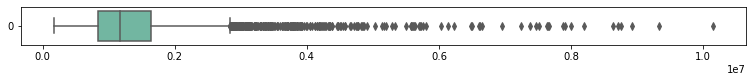

In [30]:
fig, ax = plt.subplots()
fig.set_size_inches(13, 0.7)
ax = sns.boxplot(data=df_train["Annual Income"], orient="h", palette="Set2")

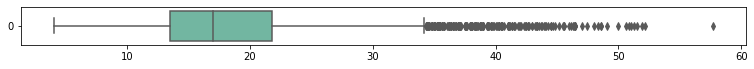

In [31]:
fig, ax = plt.subplots()
fig.set_size_inches(13, 0.7)
ax = sns.boxplot(data=df_train["Years of Credit History"], orient="h", palette="Set2")

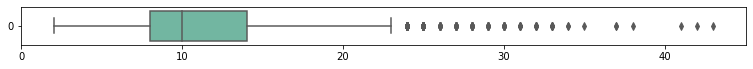

In [32]:
fig, ax = plt.subplots()
fig.set_size_inches(13, 0.7)
ax = sns.boxplot(data=df_train["Number of Open Accounts"], orient="h", palette="Set2")

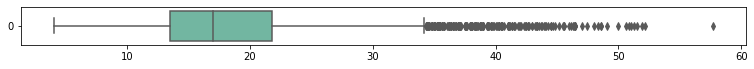

In [33]:
fig, ax = plt.subplots()
fig.set_size_inches(13, 0.7)
ax = sns.boxplot(data=df_train["Years of Credit History"], orient="h", palette="Set2")

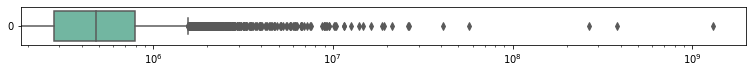

In [34]:
# логарифмическая шкала
fig, ax = plt.subplots()
fig.set_size_inches(13, 0.7)
ax = sns.boxplot(data=df_train["Maximum Open Credit"], orient="h", palette="Set2")
ax.set_xscale("log")

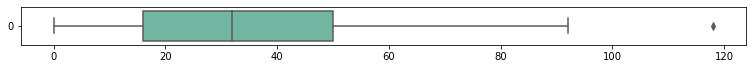

In [35]:
fig, ax = plt.subplots()
fig.set_size_inches(13, 0.7)
ax = sns.boxplot(data=df_train["Months since last delinquent"], orient="h", palette="Set2")

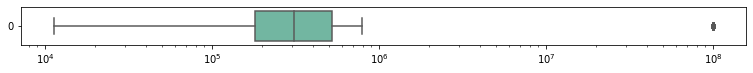

In [36]:
fig, ax = plt.subplots()
fig.set_size_inches(13, 0.7)
ax = sns.boxplot(data=df_train["Current Loan Amount"], orient="h", palette="Set2")
ax.set_xscale("log")

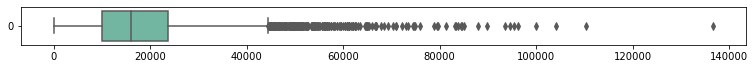

In [37]:
fig, ax = plt.subplots()
fig.set_size_inches(13, 0.7)
ax = sns.boxplot(data=df_train["Monthly Debt"], orient="h", palette="Set2")

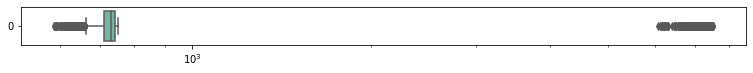

In [38]:
fig, ax = plt.subplots()
fig.set_size_inches(13, 0.7)
ax = sns.boxplot(data=df_train["Credit Score"], orient="h", palette="Set2")
ax.set_xscale("log")

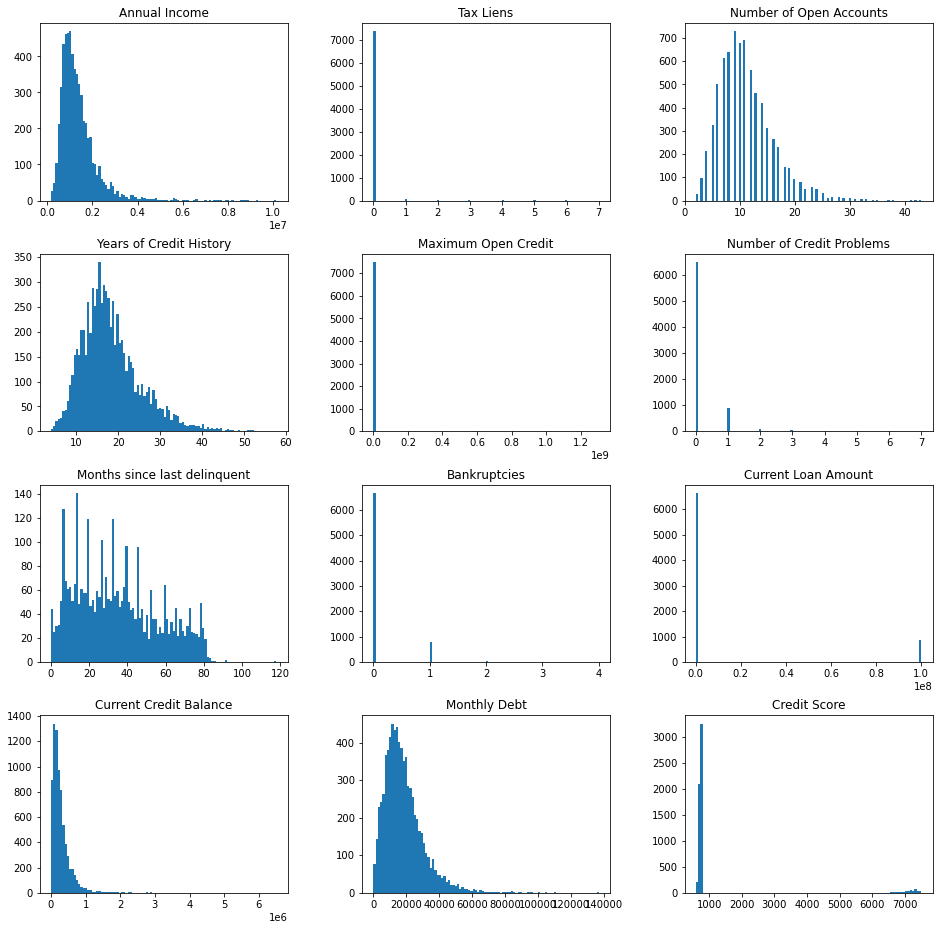

In [39]:
df_train[NUM_FEATURE_NAMES].hist(figsize=(16,16), bins=100, grid=False);

## Корреляции

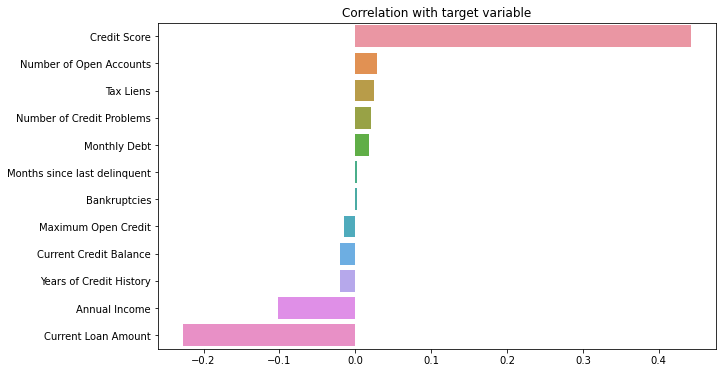

In [40]:
corr_with_target = df_train[NUM_FEATURE_NAMES + 
                            [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 6))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

Проверим признаки на корреляции Пирсона.

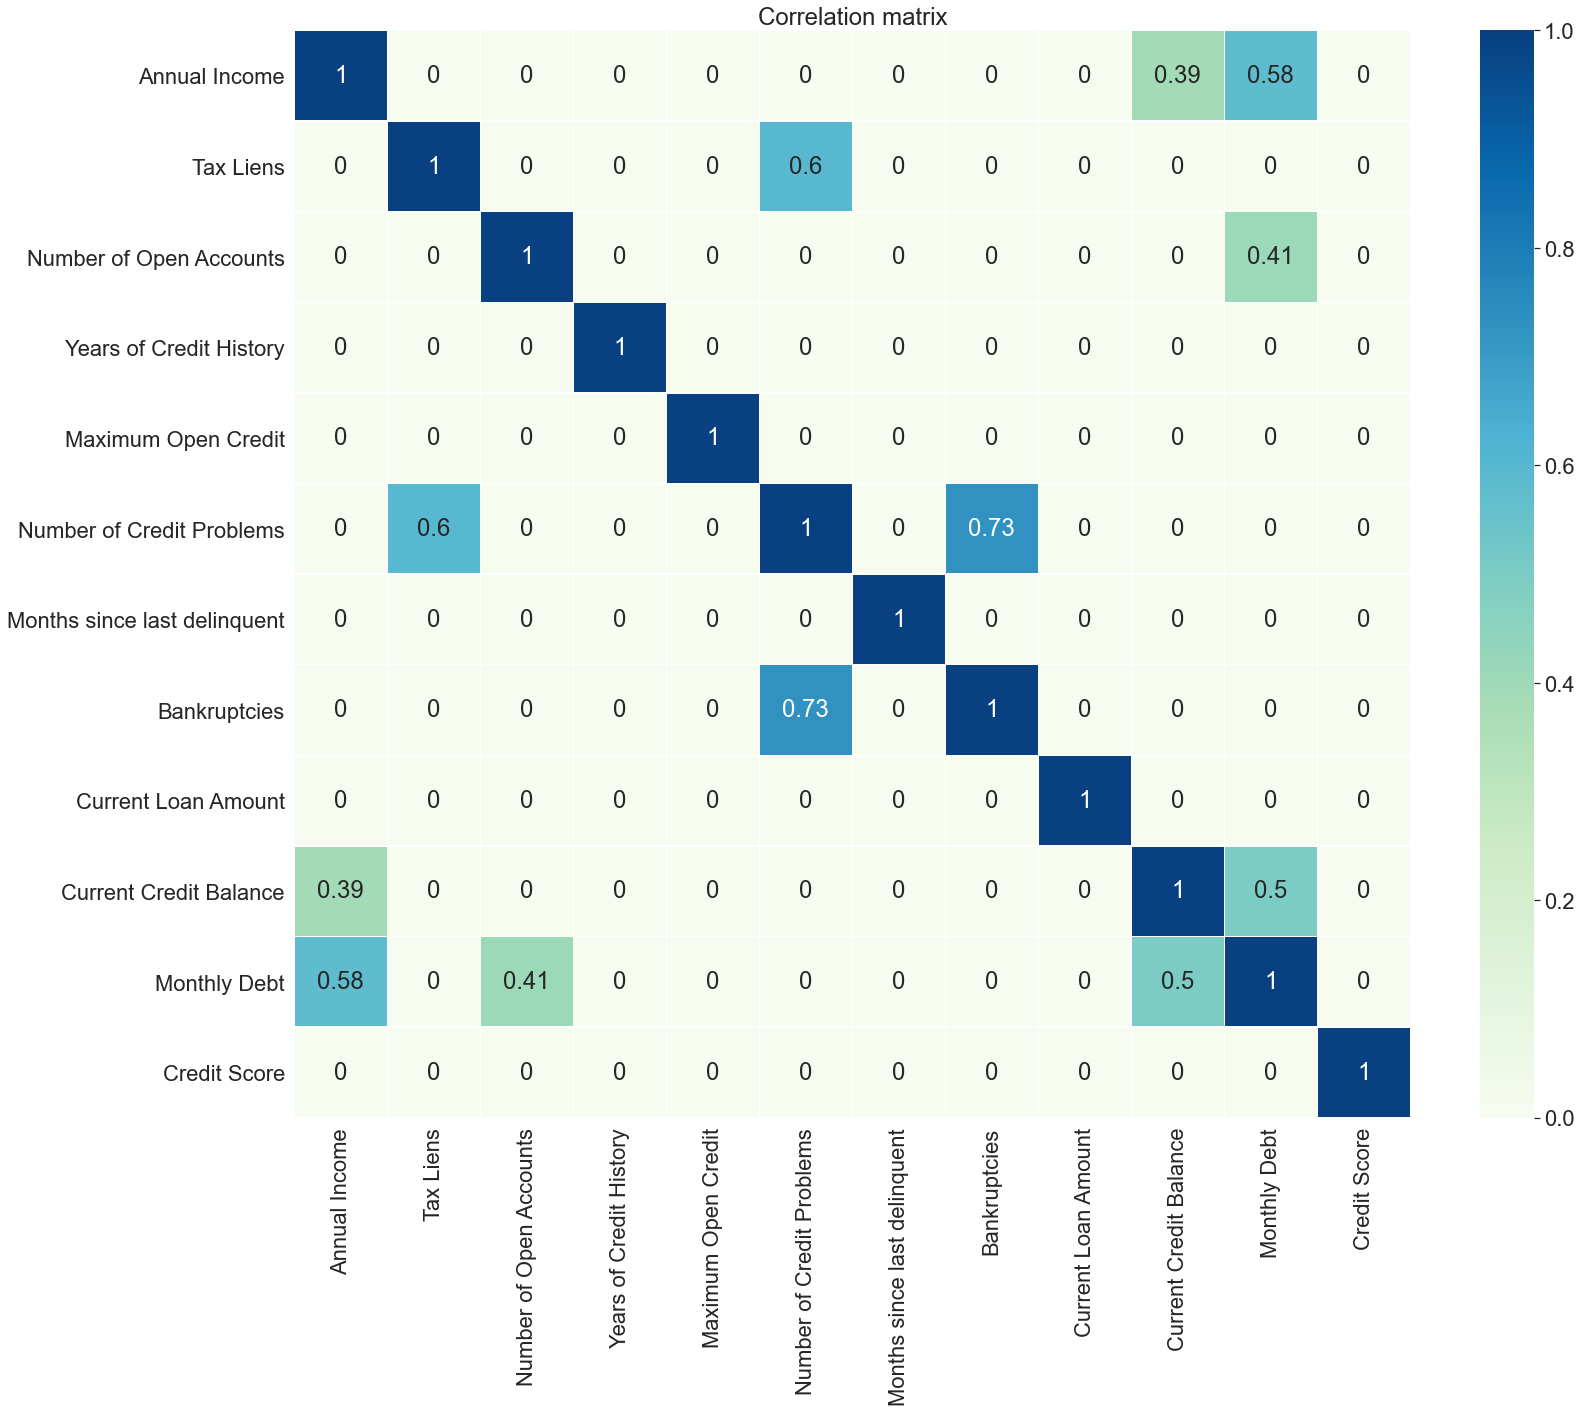

In [41]:
plt.figure(figsize = (25,20))

sns.set(font_scale=2)

corr_matrix = df_train[NUM_FEATURE_NAMES].corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

In [42]:
# вернём масштабирование шрифта для sns к 1 по умолчанию
sns.set(font_scale=1)

**Проверим распределения вещественных признаков на трейне и тесте**

Сравним их распределения

нам нужно чтобы p-value было больше 5% иначе он какой то странный и на нём лучше не обучаться.

In [43]:
from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency

Annual Income
MannwhitneyuResult(statistic=9362155.5, pvalue=0.45908193952511717)


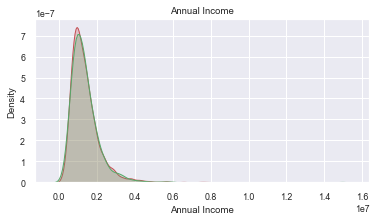

Tax Liens
MannwhitneyuResult(statistic=9336937.5, pvalue=0.09836860283803656)


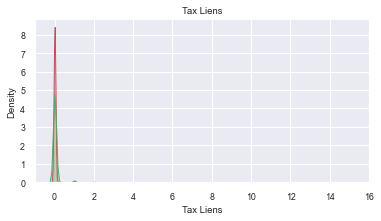

Number of Open Accounts
MannwhitneyuResult(statistic=9279311.5, pvalue=0.22142637178864455)


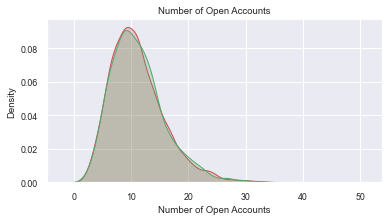

Years of Credit History
MannwhitneyuResult(statistic=9339658.0, pvalue=0.3886945952485082)


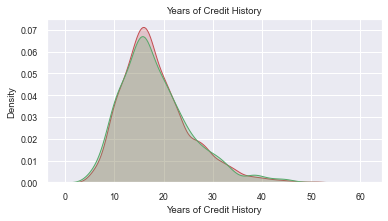

Maximum Open Credit
MannwhitneyuResult(statistic=9337869.0, pvalue=0.3832220993414893)


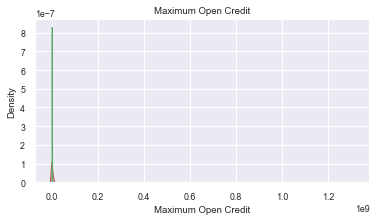

Number of Credit Problems
MannwhitneyuResult(statistic=9295513.5, pvalue=0.14195772552376257)


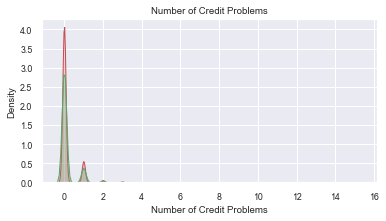

Months since last delinquent
MannwhitneyuResult(statistic=6974400.5, pvalue=1.712573746209761e-82)


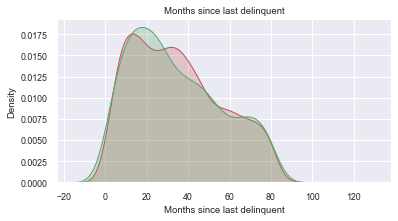

Bankruptcies
MannwhitneyuResult(statistic=9254231.0, pvalue=0.036681545859698156)


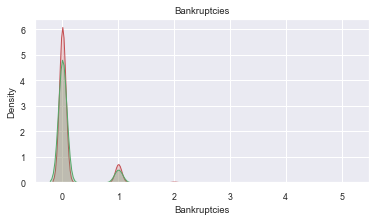

Current Loan Amount
MannwhitneyuResult(statistic=9230199.5, pvalue=0.12317435968682072)


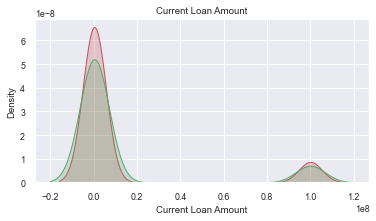

Current Credit Balance
MannwhitneyuResult(statistic=9334050.0, pvalue=0.3716147491364306)


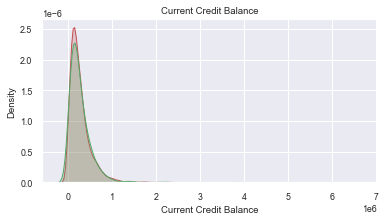

Monthly Debt
MannwhitneyuResult(statistic=9288187.0, pvalue=0.24369523330673137)


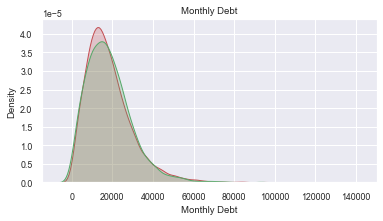

Credit Score
MannwhitneyuResult(statistic=9359581.5, pvalue=0.45091647518794764)


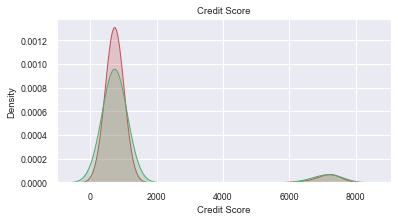

In [44]:
figsize = (6, 3)
for col in NUM_FEATURE_NAMES:
    plt.figure(figsize=figsize)
    sns.set(font_scale=0.8)
    sns.kdeplot(df_train[col], shade=True, label='train', color='r')
    sns.kdeplot(df_test[col], shade=True, label='test', color='g')
    print(col)
    print(mannwhitneyu(df_train[col], df_test[col]))
    plt.title(col)
    plt.show()

## Распределения категориальных признаков на трейне и тесте

**Проверим распределения категориальных признаков на трейне и тесте**

Целевая переменная есть только на трейне и нам нужно как-то выкручиваться, чтобы понимать насколько выборки между собой похожи.

Years of Credit History имел самый высокий уровень значимости, значит в его разрезе будем смотреть на категории.

Нужно чтобы зелёные (тест) доверительные интервалы были похожи на красные (трейн).

Purpuse трейна имеет на 1 значение больше чем теста.

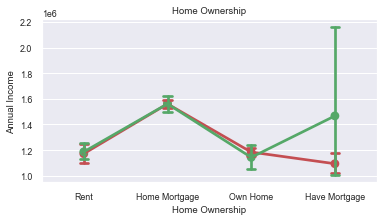

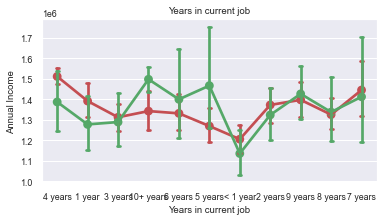

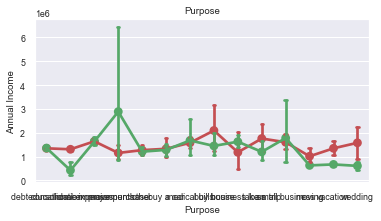

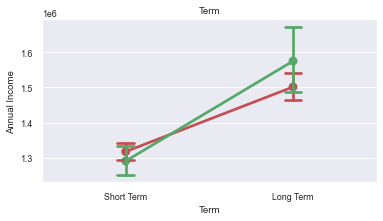

In [45]:
num_feature = 'Annual Income'
for col in CAT_FEATURE_NAMES:
    plt.figure(figsize=figsize)
    sns.pointplot(x=col, y=num_feature, data=df_train, capsize=.1, label='train', color='r')
    sns.pointplot(x=col, y=num_feature, data=df_test, capsize=.1, label='test', color='g')
    plt.title(col) 
    plt.show()

Построим доверительные интервалы по 2-му признаку с нивысшим p-value Credit Score.

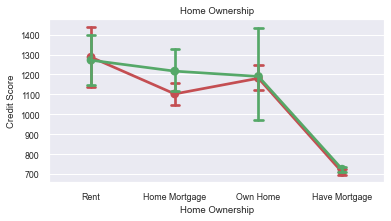

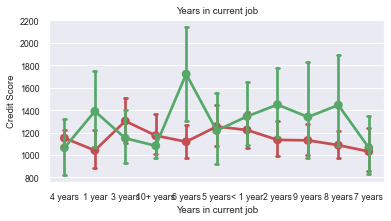

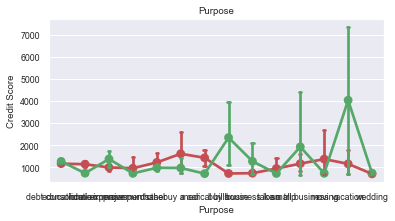

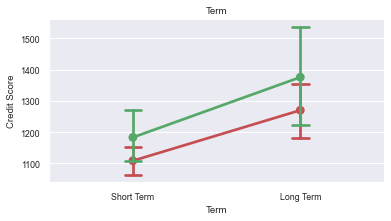

In [46]:
num_feature = 'Credit Score'
for col in CAT_FEATURE_NAMES:
    plt.figure(figsize=figsize)
    sns.pointplot(x=col, y=num_feature, data=df_train, capsize=.1, label='train', color='r')
    sns.pointplot(x=col, y=num_feature, data=df_test, capsize=.1, label='test', color='g')
    plt.title(col)
    plt.show()

Построим доверительные интервалы по признаку Years of Credit History.

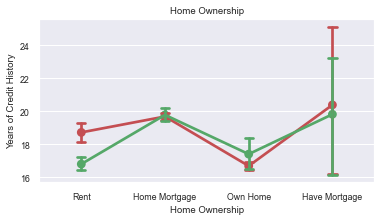

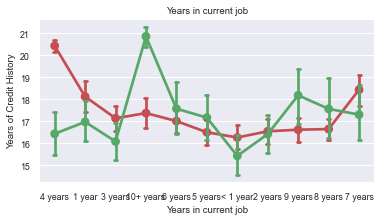

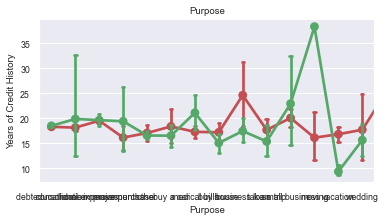

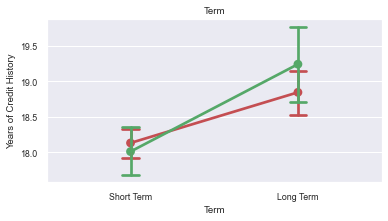

In [47]:
num_feature = 'Years of Credit History'
for col in CAT_FEATURE_NAMES:
    plt.figure(figsize=figsize)
    sns.pointplot(x=col, y=num_feature, data=df_train, capsize=.1, label='train', color='r')
    sns.pointplot(x=col, y=num_feature, data=df_test, capsize=.1, label='test', color='g')
    plt.title(col)
    plt.show()

Посмотрим распределение по заёмщиков по типу проживания.

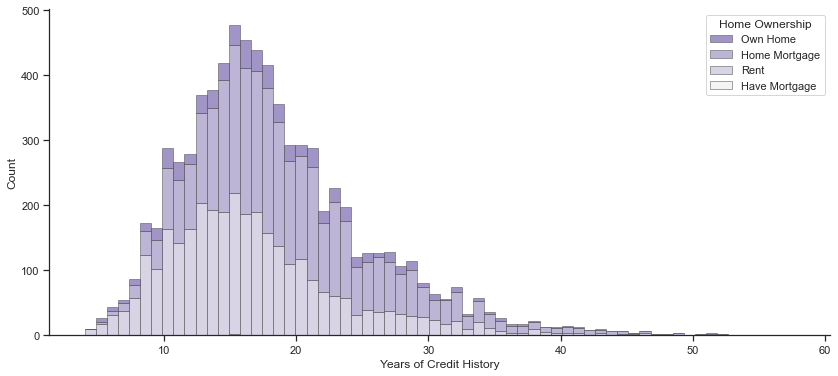

In [48]:
sns.set_theme(style="ticks")
f, ax = plt.subplots(figsize=(14, 6))
sns.despine(f)

sns.histplot(
    df_train,
    x="Years of Credit History", hue="Home Ownership",
    multiple="stack",
    palette="light:m_r",
    edgecolor=".3",
    linewidth=.5,
    #log_scale=True,
)
ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
#ax.set_xticks([500, 1000, 2000, 5000, 10000])

Посмотрим на распределение дохода и лет кредитной истории и проверим есть ли зависимости кредитных просрочек.

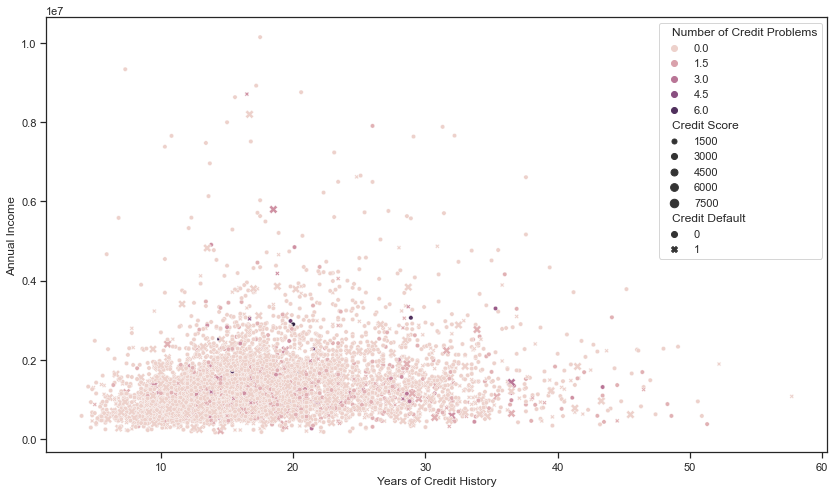

In [49]:
fig, ax = plt.subplots(figsize=(14,8)) 
sns.scatterplot(data=df_train, x="Years of Credit History", y="Annual Income",
                size='Credit Score', 
                style="Credit Default",
                hue='Number of Credit Problems',
               );

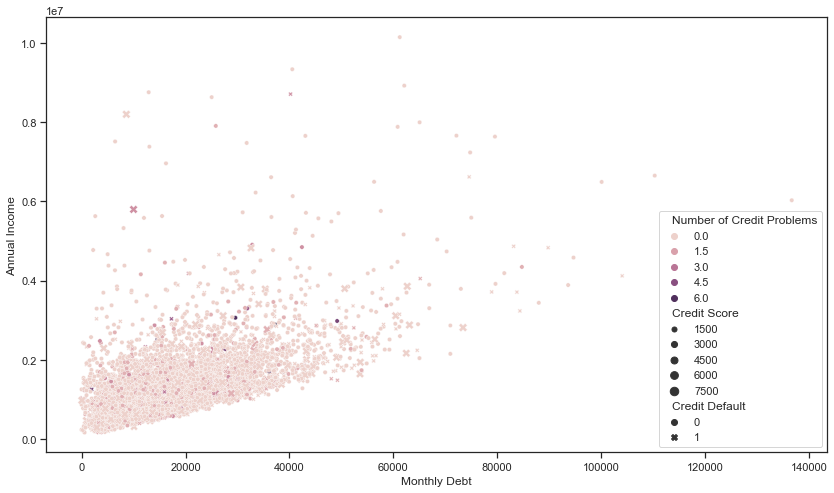

In [50]:
fig, ax = plt.subplots(figsize=(14,8)) 
sns.scatterplot(data=df_train, x="Monthly Debt", y="Annual Income",
                size='Credit Score', 
                style="Credit Default",
                hue='Number of Credit Problems',
               );

Посмотрим как распределяются признаки в разрезе Credit Default.

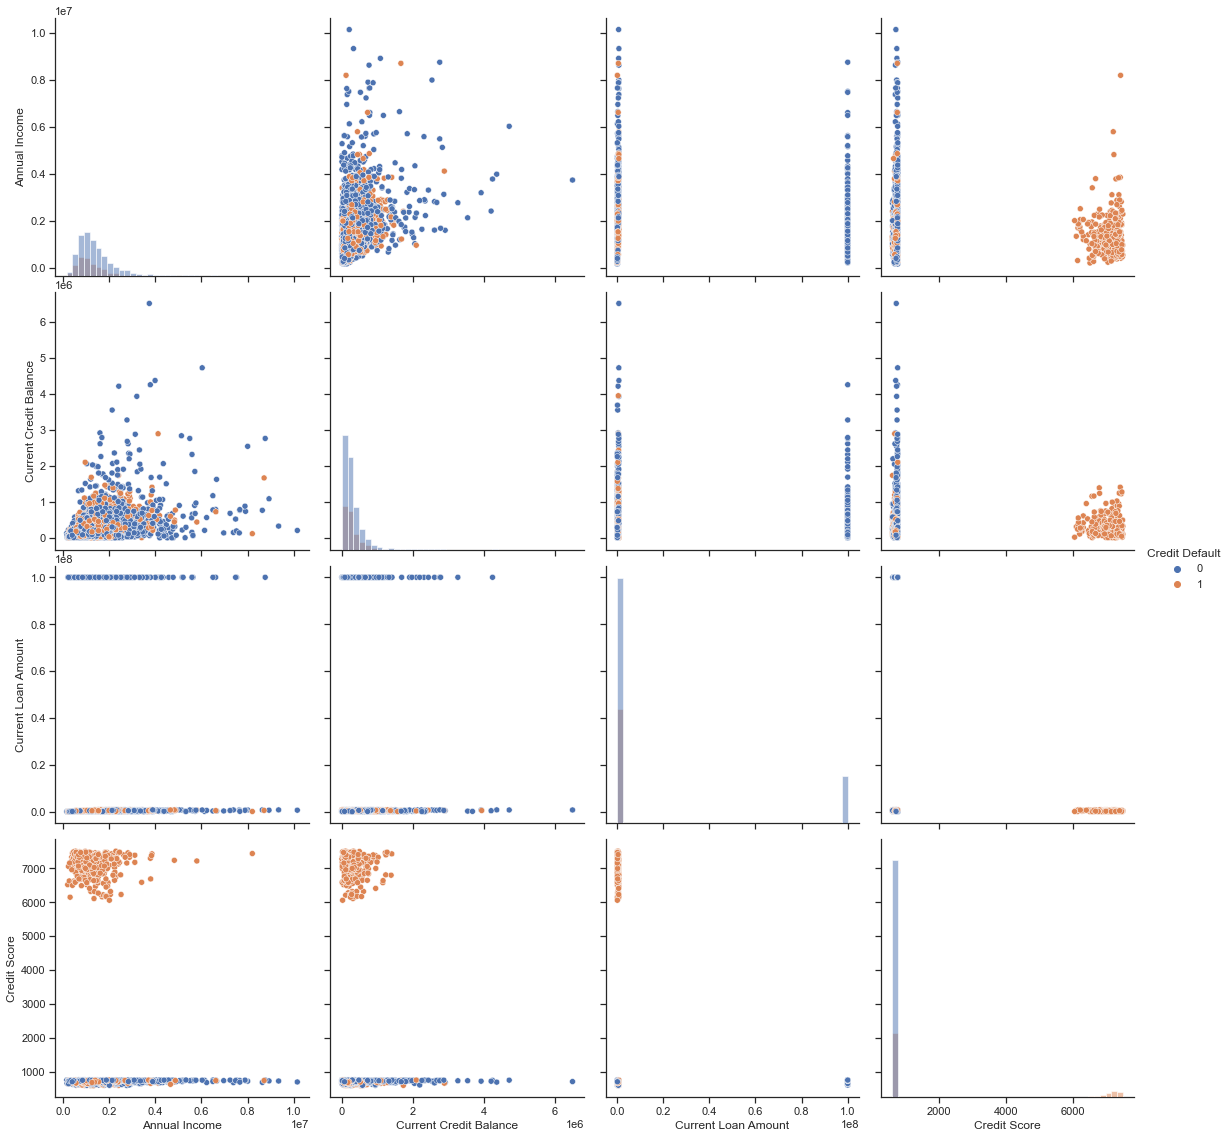

In [51]:
grid = sns.PairGrid(data=df_train, hue='Credit Default',
                    vars = ['Annual Income', 'Current Credit Balance', 
                    'Current Loan Amount', 'Credit Score'], size = 4)

grid = grid.map_upper(sns.scatterplot)
grid.map_diag(sns.histplot, bins = 40)
grid = grid.map_lower(sns.scatterplot)
grid.add_legend();

У объектов с Current Loan Amount = 1 всегда Credit Default = 1

У объектов с Credit score > 6000, Credit Default = 1

Проверим распределение данных и выбросы

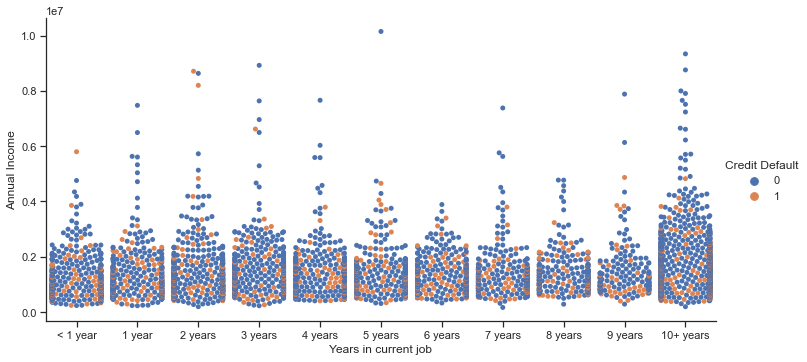

In [52]:
sns.catplot(x="Years in current job", y="Annual Income", hue="Credit Default", 
            kind="swarm", aspect=2, data=df_train,
            order=['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years',
                  '6 years', '7 years', '8 years', '9 years', '10+ years']);

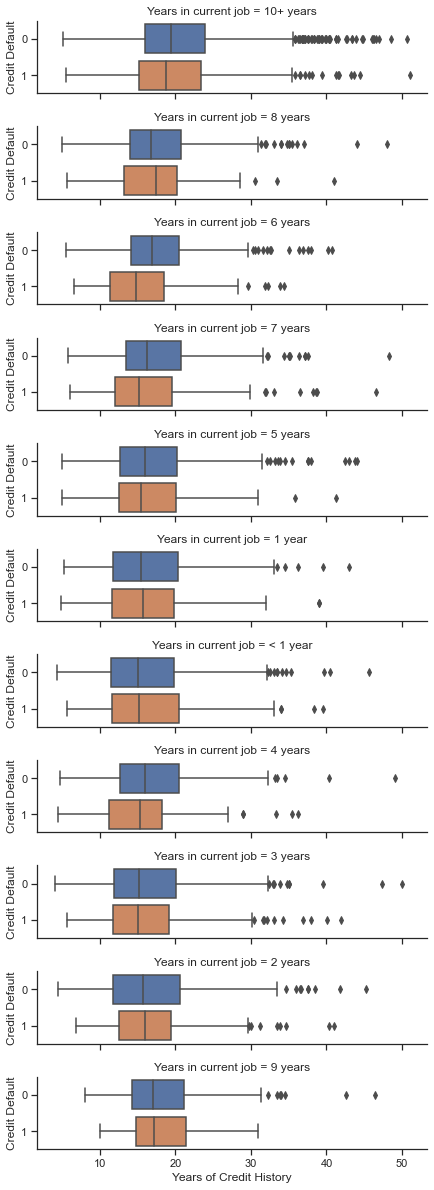

In [53]:
g = sns.catplot(x="Years of Credit History", y='Credit Default', row='Years in current job',
                kind="box", orient="h", height=1.5, aspect=4,
                data=df_train)
g.set();

Посмотрим на распределение в зависимости от того долгосрочный или краткосрочный кредит.

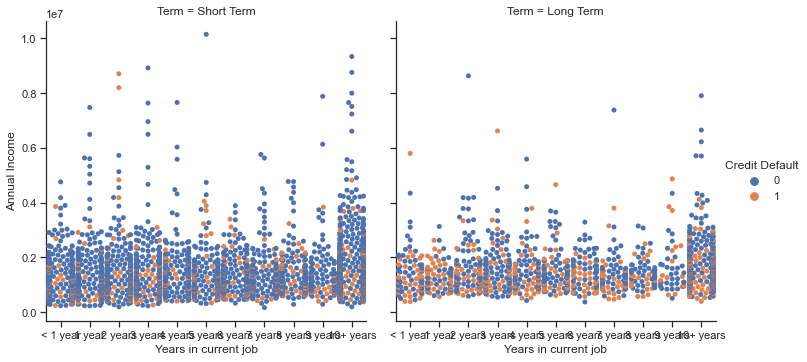

In [54]:
sns.catplot(x="Years in current job", y="Annual Income", 
            hue="Credit Default", col="Term", 
            aspect=1, kind="swarm", data=df_train,
            order=['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years',
                  '6 years', '7 years', '8 years', '9 years', '10+ years']);

Посмотрим как распределяются категориальные признаки по предсказываемым классам.

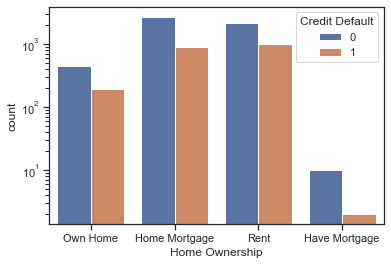

In [55]:
sns.countplot(df_train['Home Ownership'], hue=df_train['Credit Default'], log=True);

Люди, имеющие ипотеку допускают кредитный дефолт значительно реже.

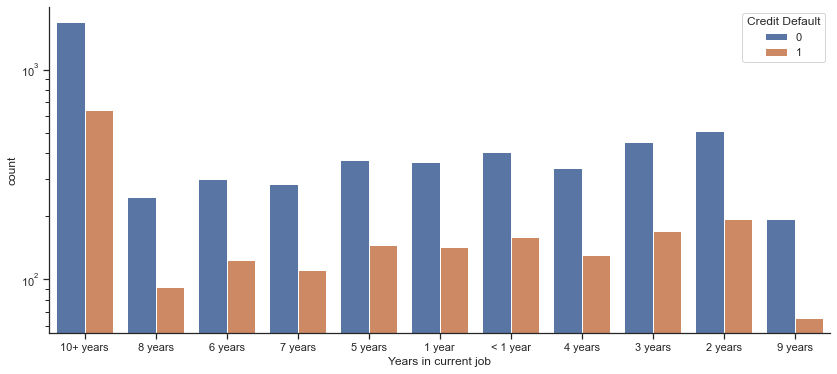

In [56]:
f, ax = plt.subplots(figsize=(14, 6))
sns.despine(f)
sns.countplot(df_train['Years in current job'], hue=df_train['Credit Default'], log=True);

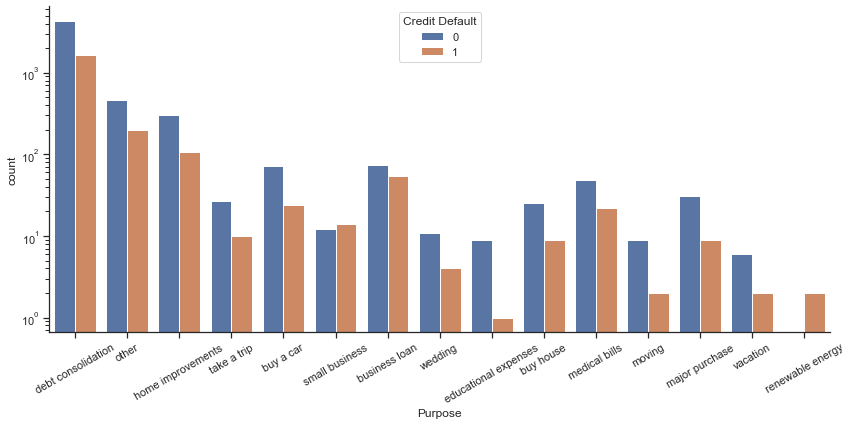

In [57]:
f, ax = plt.subplots(figsize=(14, 6))
sns.despine(f)
sns.countplot(df_train['Purpose'], hue=df_train['Credit Default'], log=True)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30);

Все кто брали кредит на renewable energy допустили кредитный дефолт.

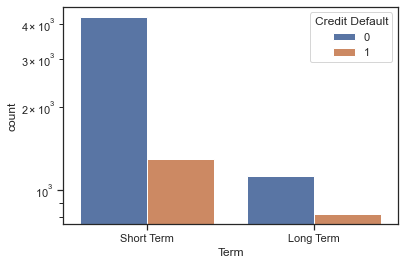

In [58]:
sns.countplot(df_train['Term'], hue=df_train['Credit Default'], log=True);

### Обработка данных с пропусками

Тестирование показало, что ниилучший скор достигается выбросом даных с пропусками

In [59]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)
print('Original dataset shape = ', df_train.shape)

df_train.dropna(axis='index', inplace=True) 
print('Dataset shape wothout NaN = ', df_train.shape)

Original dataset shape =  (7500, 17)
Dataset shape wothout NaN =  (2585, 17)


In [60]:
LogRegression(df_train)

'f1 class 1: TRAIN = 0.8115, TEST = 0.7977'

In [61]:
knn(df_train)

'f1 class 1: TRAIN = 0.7828, TEST = 0.6997'

In [62]:
decision_tree(df_train, max_depth=2)

'f1 class 1: TRAIN = 0.8043, TEST = 0.8015'

In [63]:
xgboost(df_train, n_estimators=10)

[00:24:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


'f1 class 1: TRAIN = 0.8563, TEST = 0.8041'

In [64]:
light_gbm(df_train)

'f1 class 1: TRAIN = 0.9038, TEST = 0.7358'

In [65]:
# tuning
light_gbm(df_train, num_leaves=2)

'f1 class 1: TRAIN = 0.7529, TEST = 0.7307'

In [66]:
cat_boost(df_train)

'f1 class 1: TRAIN = 0.9663, TEST = 0.7668'

Model | Baseline | Dropped NaN
---|---|---
LogReg | TRAIN = 0.7817, TEST = 0.768 | TRAIN = 0.8115, TEST = 0.7977
KNN | TRAIN = 0.7813, TEST = 0.6747' | TRAIN = 0.7828, TEST = 0.6997
Decision Tree | TRAIN = 0.7726, TEST = 0.7693 | TRAIN = 0.8043, TEST = 0.8015
XGB | TRAIN = 0.8038, TEST = 0.7698 | TRAIN = 0.8563, TEST = 0.8041
LGBM | TRAIN = 0.8072, TEST = 0.7018 | TRAIN = 0.9038, TEST = 0.7358
CatB | TRAIN = 0.9025, TEST = 0.7156 | TRAIN = 0.9663, TEST = 0.7668

Вывод: выбрасывание пропущенных значений значительно улучшило скор по сравнению с заполнением модой. Лучше всего себя показало Decision Tree и XGB.

# Финальная модель

Подбор гиперпараметров с помощью GridSearch показал, что наилучшими для CatBoost являются параметры: {'depth': 9, 'l2_leaf_reg': 920.921} 

In [67]:
# ОБУЧЕНИЕ CatBoost НА ВСЕЙ ВЫБОРКЕ И ПРЕДСКАЗАНИЕ

# загрузка данных
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)
print('Original dataset shape = ', df_train.shape)

# Удаление пропусков
df_train.dropna(axis='index', inplace=True) 
print('Dataset shape without NaN = ', df_train.shape)

# заполнение пропусков теста
df_test[CAT_FEATURE_NAMES] = df_test[CAT_FEATURE_NAMES].fillna(df_test.mode().iloc[0])
df_test[NUM_FEATURE_NAMES] = df_test[NUM_FEATURE_NAMES].fillna(df_test.median())


df = df_train

# подсчитываем дисбаланс классов
class_weight = df[TARGET_NAME].value_counts()[1] / df[TARGET_NAME].value_counts()[0]


# формируем выборки
X = df.drop(columns=[TARGET_NAME])
y = df[TARGET_NAME]

frozen_params = {
    'class_weights':[class_weight, 1], 
    'eval_metric':'F1',
    'cat_features':CAT_FEATURE_NAMES,
    'one_hot_max_size':len(X.columns),
    'silent':True,
    'random_state':21,
                }

# обучаем модель
model = catb.CatBoostClassifier(**frozen_params,
                                depth=9, 
                                l2_leaf_reg=920.921,
                               )
model.fit(X, y)

# предсказываем
y_train_pred = model.predict(X)
y_pred = model.predict(df_test)

# считаем метрики
#evaluate_preds(model, X_train, X_test, y_train, y_test)
accuracy_train = accuracy_score(y, y_train_pred)

print(f'f1 class 1: TRAIN = {round(accuracy_train, 4)}')

Original dataset shape =  (7500, 17)
Dataset shape without NaN =  (2585, 17)
f1 class 1: TRAIN = 0.8182


In [68]:
y_pred

array([0, 1, 1, ..., 1, 0, 1], dtype=int64)

In [69]:
submission = pd.DataFrame()
submission['Credit Default'] = y_pred
submission.to_csv(f'data/AKalinichenko_CatB_final_predictions.csv', 
                  index_label='Id', 
                  header=['Credit Default'], 
                  index=True, 
                  encoding='utf-8')
print('Done!')

Done!
